In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras import regularizers
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import pickle
from sklearn.metrics import confusion_matrix
from PyFunctions import Functions as func
from PyFunctions import var
from PyFunctions import Viz
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

Using plaidml.keras.backend backend.


# VGG16

In [2]:
def get_vgg16(dim):
    model = Sequential()
    baseModel = VGG16(weights="imagenet", include_top=False,
        input_tensor=Input(shape=dim))
    
    model.add(baseModel)
    headModel = model.add(AveragePooling2D(pool_size=(7, 7)))
    headModel = model.add(Flatten(name="flatten"))
    headModel = model.add(Dense(128, activation="relu"))
    headModel = model.add(Dropout(0.3))
    headModel = model.add(Dense(3, activation="softmax", name = 'Output'))

    # place the head FC model on top of the base model (this will become
    # the actual model we will train)


    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable = False
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model


In [3]:
x_train, x_test, y_train, y_test = func.get_tts('vgg16', version =2, edge =False, balance = True)

Train Value Counts
1    1368
0    1368
2    1233
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Test Value Counts
1    152
0    152
2    137
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Train Shape
(3969, 224, 224, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Test Shape
(441, 224, 224, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


## V1: Augment

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/VGGV1_Augment.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 5, mode = 'min')
epochs = 2000
batch_size = 16
    
dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
vgg16 = get_vgg16(dim =dim)

    
augmentation =ImageDataGenerator(rotation_range = 20, width_shift_range = .2, height_shift_range = .2, 
                                                       horizontal_flip = True, shear_range = .15, 
                                 fill_mode = 'nearest', zoom_range = .15)
augmentation.fit(x_train)
mobilenet_history = vgg16.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

Epoch 1/2000
249/249 [==============================] - 129s 517ms/step - loss: 0.6849 - acc: 0.6855 - val_loss: 0.6191 - val_acc: 0.7166

Epoch 00001: val_loss improved from inf to 0.61909, saving model to ModelWeights/VGGV1_Augment.h5
Epoch 2/2000
249/249 [==============================] - 109s 436ms/step - loss: 0.5725 - acc: 0.7620 - val_loss: 0.5778 - val_acc: 0.7347

Epoch 00002: val_loss improved from 0.61909 to 0.57783, saving model to ModelWeights/VGGV1_Augment.h5
Epoch 3/2000
249/249 [==============================] - 108s 435ms/step - loss: 0.5266 - acc: 0.7796 - val_loss: 0.5475 - val_acc: 0.7438

Epoch 00003: val_loss improved from 0.57783 to 0.54747, saving model to ModelWeights/VGGV1_Augment.h5
Epoch 4/2000
249/249 [==============================] - 108s 436ms/step - loss: 0.4897 - acc: 0.7999 - val_loss: 0.5082 - val_acc: 0.7664

Epoch 00004: val_loss improved from 0.54747 to 0.50822, saving model to ModelWeights/VGGV1_Augment.h5
Epoch 5/2000
249/249 [==================

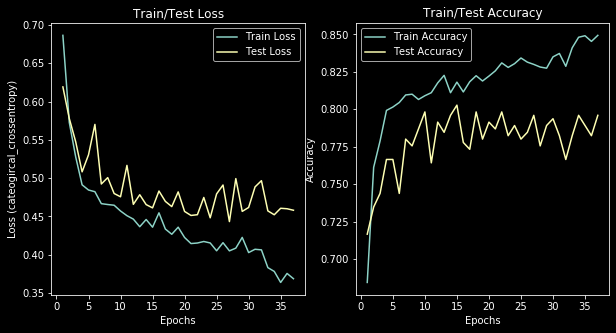

In [11]:
Viz.plot_loss_accuracy(mobilenet_history, 'dark_background', path = 'figures/VGGV1LossAcc_Augment.png')  

F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.915032679738562
HandGun: 0.7138047138047138
Rifle: 0.7526881720430106


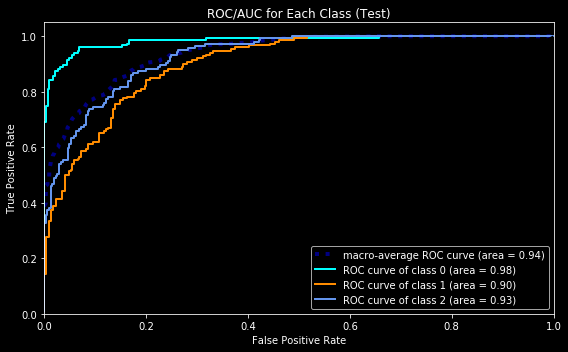

In [13]:
dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
vgg16 = get_vgg16(dim =dim)
vgg16.load_weights('ModelWeights/VGGV1_Augment.h5') #load the best weights before overfitting

Viz.plot_roc_auc(vgg16, x_test, y_test, 'dark_background', 'figures/VGGV1ROC_Augment.png')

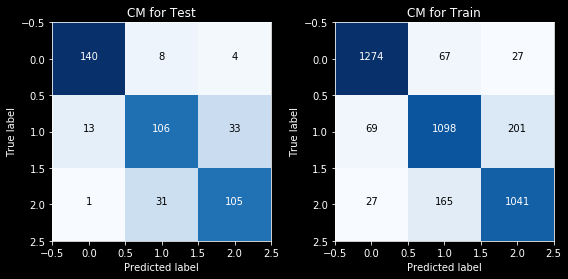

In [14]:
dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
vgg16 = get_vgg16(dim =dim)
vgg16.load_weights('ModelWeights/VGGV1_Augment.h5') #load the best weights before overfitting

y_test_prob = [np.argmax(i) for i in vgg16.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in vgg16.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/VGGV1CM_Augment.png')

### V1: No Augment

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/VGGV1_NoAugment.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 5, mode = 'min')
epochs = 2000
batch_size = 16
    
dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
vgg16 = get_vgg16(dim =dim)

mobilenet_history = vgg16.fit(x_train, y_train, batch_size = batch_size,
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


Train on 3969 samples, validate on 441 samples
Epoch 1/2000
3969/3969 [==============================] - 129s 32ms/step - loss: 0.6526 - acc: 0.7120 - val_loss: 0.5672 - val_acc: 0.7438

Epoch 00001: val_loss improved from inf to 0.56721, saving model to ModelWeights/VGGV1_NoAugment.h5
Epoch 2/2000
3969/3969 [==============================] - 109s 28ms/step - loss: 0.5293 - acc: 0.7848 - val_loss: 0.5301 - val_acc: 0.7619

Epoch 00002: val_loss improved from 0.56721 to 0.53007, saving model to ModelWeights/VGGV1_NoAugment.h5
Epoch 3/2000
3969/3969 [==============================] - 110s 28ms/step - loss: 0.4832 - acc: 0.7974 - val_loss: 0.5334 - val_acc: 0.7596

Epoch 00003: val_loss did not improve from 0.53007
Epoch 4/2000
3969/3969 [==============================] - 110s 28ms/step - loss: 0.4591 - acc: 0.8105 - val_loss: 0.4986 - val_acc: 0.7914

Epoch 00004: val_loss improved from 0.53007 to 0.49863, saving model to ModelWeights/VGGV1_NoAugment.h5
Epoch 5/2000
3969/3969 [==========

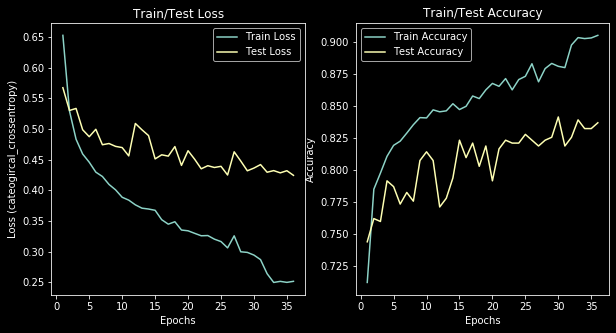

In [5]:
Viz.plot_loss_accuracy(mobilenet_history, 'dark_background', path = 'figures/VGGV1LossAcc_NoAugment.png')  

F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.9215686274509804
HandGun: 0.7911392405063291
Rifle: 0.7923076923076922


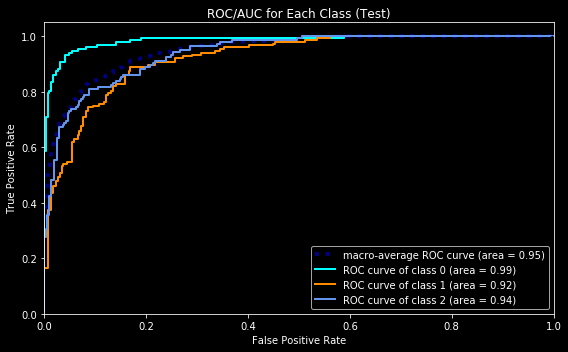

In [8]:
dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
vgg16 = get_vgg16(dim =dim)
vgg16.load_weights('ModelWeights/VGGV1_NoAugment.h5') #load the best weights before overfitting

Viz.plot_roc_auc(vgg16, x_test, y_test, 'dark_background', 'figures/VGGV1ROC_NoAugment.png')

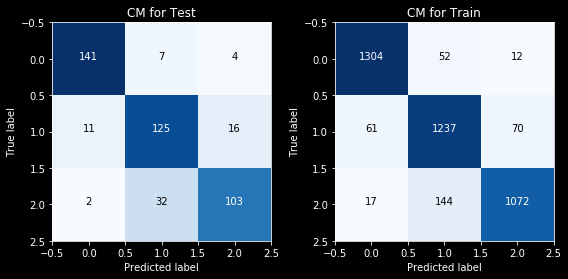

In [9]:
dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
vgg16 = get_vgg16(dim =dim)
vgg16.load_weights('ModelWeights/VGGV1_NoAugment.h5') #load the best weights before overfitting

y_test_prob = [np.argmax(i) for i in vgg16.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in vgg16.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/VGGV1CM_NoAugment.png')

In [ ]:
// %%javascript
// IPython.notebook.save_notebook()

In [ ]:
import os
os.system(r'%windir%\system32\rundll32.exe powrprof.dll,SetSuspendState Hibernate')